In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
CONFIG_DIR = '../app/'

In [6]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [7]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-21'

In [8]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [9]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664128734,40253,23764,sell,0x001f581ca7fb3a01bd2c7ef4577e1bf22e15e7c0,NaN,0.79,sneakers,common,sprinter,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.288660
1,1664128701,40252,23732,sell,0x001f581ca7fb3a01bd2c7ef4577e1bf22e15e7c0,NaN,0.79,sneakers,common,sprinter,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
2,1664128644,40251,27717,sell,0x80c9ff9bc539238e15dbd76013aa07708a3ac30c,NaN,0.72,sneakers,common,sprinter,...,564.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.297578
3,1664128617,39950,27717,cancel,0x80c9ff9bc539238e15dbd76013aa07708a3ac30c,NaN,NaN,sneakers,common,sprinter,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
4,1664128605,40250,40428,sell,0x079220557729cceef4ec3e33110c9b402bb9db32,NaN,1.31,sneakers,common,hiker,...,564.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.289655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52535,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
52536,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
52537,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
52538,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [10]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [11]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52540 entries, 0 to 52539
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  37166 non-null  float64
 1   time_ownership             37166 non-null  float64
 2   wallet_box_mint            37166 non-null  float64
 3   wallet_sneaker_mint        37166 non-null  float64
 4   time_level_up              34082 non-null  float64
 5   time_level_up_for_mint     37166 non-null  float64
 6   base_mint_price_amt        37166 non-null  float64
 7   base_mint_price_azy        37166 non-null  float64
 8   base_mint_price_bnb        27143 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


In [12]:
data.genesis

0         True
1         True
2         True
3         True
4        False
         ...  
52535     True
52536    False
52537    False
52538    False
52539     True
Name: genesis, Length: 52540, dtype: bool

In [13]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
7,1664128560,39960,22896,buy,0x80917adc261c0eab8839f0b861fe698a8a88f9c9,0x10db1a53d39adcb8505c6f90b6ed25c7ef5566d1,0.74,sneakers,common,ranger,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.278351
19,1664128296,40213,45491,buy,0x2e15b5515eddbacb4ff389b9128139c11773a542,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.69,sneakers,common,ranger,...,567.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
23,1664128230,40066,31039,buy,0xb6249d0e0c5678c5029728a98b50f31c176e7b48,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.68,sneakers,common,ranger,...,569.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.291096
33,1664128110,40224,31290,buy,0xfe7e2202fdc75bc2562d0f00ab0f27b13f09fb71,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.66,sneakers,common,ranger,...,573.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.311644
42,1664128014,39963,53277,buy,0xc5d01c99b5ff377fd5a9c66ce5d288942afd84ec,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.67,sneakers,common,ranger,...,578.0,8540.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.300676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52477,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
52500,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
52514,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
52519,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [14]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [15]:
data['mint'].isna().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 7 to 52533
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        9718 non-null   int64  
 1   mrk_id                                           9718 non-null   int64  
 2   token_id                                         9718 non-null   int64  
 3   event                                            9718 non-null   object 
 4   wallet_from                                      9718 non-null   object 
 5   wallet_to                                        9718 non-null   object 
 6   price                                            9718 non-null   float64
 7   item_type                                        9718 non-null   object 
 8   rarity                                           9718 non-null   object 
 9   sneaker_type                 

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 7 to 52533
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  9718 non-null   float64
 1   time_ownership             9718 non-null   float64
 2   wallet_box_mint            9718 non-null   float64
 3   wallet_sneaker_mint        9718 non-null   float64
 4   time_level_up              9718 non-null   float64
 5   time_level_up_for_mint     9718 non-null   float64
 6   base_mint_price_amt        9718 non-null   float64
 7   base_mint_price_azy        9718 non-null   float64
 8   base_mint_price_bnb        7328 non-null   float64
dtypes: float64(9)
memory usage: 759.2 KB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
7,1.657836e+09,13798.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.595790
19,1.662571e+09,1563.0,2.0,2.0,900.0,1800.0,300.0,200.0,0.595790
23,1.659388e+09,3375111.0,12.0,19.0,900.0,1800.0,300.0,200.0,0.596687
33,1.657868e+09,3319316.0,3.0,3.0,900.0,1800.0,300.0,200.0,0.596687
42,1.657806e+09,470466.0,16.0,15.0,900.0,1800.0,300.0,200.0,0.596687
...,...,...,...,...,...,...,...,...,...
52477,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
52500,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
52514,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
52519,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 7 to 52533
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        9718 non-null   int64  
 1   mrk_id                                           9718 non-null   int64  
 2   token_id                                         9718 non-null   int64  
 3   event                                            9718 non-null   object 
 4   wallet_from                                      9718 non-null   object 
 5   wallet_to                                        9718 non-null   object 
 6   price                                            9718 non-null   float64
 7   item_type                                        9718 non-null   object 
 8   rarity                                           9718 non-null   object 
 9   sneaker_type                 

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
7,1664128560,39960,22896,buy,0x80917adc261c0eab8839f0b861fe698a8a88f9c9,0x10db1a53d39adcb8505c6f90b6ed25c7ef5566d1,0.74,sneakers,common,ranger,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.278351
19,1664128296,40213,45491,buy,0x2e15b5515eddbacb4ff389b9128139c11773a542,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.69,sneakers,common,ranger,...,567.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
23,1664128230,40066,31039,buy,0xb6249d0e0c5678c5029728a98b50f31c176e7b48,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.68,sneakers,common,ranger,...,569.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.291096
33,1664128110,40224,31290,buy,0xfe7e2202fdc75bc2562d0f00ab0f27b13f09fb71,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.66,sneakers,common,ranger,...,573.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.311644
42,1664128014,39963,53277,buy,0xc5d01c99b5ff377fd5a9c66ce5d288942afd84ec,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.67,sneakers,common,ranger,...,578.0,8540.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.300676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52477,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
52500,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
52514,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
52519,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [26]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
52044,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,16182,4070,391,4746,5443,16182,NaN,NaN,2022-08-21 10:15:49
51993,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,16191,4072,387,4748,5448,16191,NaN,NaN,2022-08-21 10:55:43
51790,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,16227,4332,384,4770,5469,16227,NaN,NaN,2022-08-21 13:12:37
51595,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,16258,4083,380,4791,5492,16258,NaN,NaN,2022-08-21 15:32:25
50864,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,16415,4126,251,4875,5592,16415,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1664121833,39986,28997,buy,0xb319e3b7580c83a0cb8047eef66997b20b549689,0xc4b3410374f770997c43e65b2b4c55f039cb3205,0.69,sneakers,common,hiker,...,8530.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.332258,2022-09-25 16:03:53
284,1664122151,40112,31229,buy,0x8f1a2341519a63d3a808e60575012f4625cf34ad,0x9847e6be465e29370a90c680a977c516f1abee6b,0.63,sneakers,common,ranger,...,8528.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.335484,2022-09-25 16:09:11
83,1664127114,40222,47112,buy,0xf191581b3e5c7e2bd4fbfb838604b28b38264024,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.66,sneakers,common,ranger,...,8537.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.318937,2022-09-25 17:31:54
62,1664127438,39291,55037,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x2684ea68d5da1df502005991e47f33924fd8bd7f,1.00,sneakers,common,coacher,...,8539.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.312081,2022-09-25 17:37:18


In [27]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [28]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [30]:
data['token_sell_activity_6H'].max()

11

In [31]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [32]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [33]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H
37380,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,3942,323,1584,4052,13161,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
33142,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,4018,287,2007,3803,9987,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [34]:
len(dupl_df)

2327

In [35]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [36]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,16155,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16168,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16169,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,16191,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,16204,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1664034934,38935,58754,buy,0x919938c67fda32f3c64477c56679a32b93503dd8,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.73,sneakers,common,ranger,...,count_new_sneaker_30d,93.0,1.069536,2022-09-24 15:55:34,1564,3.034884,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.85,2022-09-24 18:00:04,0.0775
1066,1664038477,38963,48843,buy,0x7bf059b6fd6d2d58d0fb3d27b33fc606f623fd27,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.75,sneakers,common,ranger,...,count_new_sneaker_30d,92.0,1.087248,2022-09-24 16:54:37,1553,3.023346,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.79,2022-09-24 18:39:05,0.0005
1067,1664047154,39055,51181,buy,0x318bcf944e2acefec20af0448c8d485ec2bc797b,0xbd1ff5e92de49932750fe4709ae5d788cc16b0ef,0.72,sneakers,common,sprinter,...,count_new_sneaker_30d,94.0,1.040816,2022-09-24 19:19:14,1547,2.901887,0xbd1ff5e92de49932750fe4709ae5d788cc16b0ef,0.85,2022-09-25 11:01:57,0.0875
1068,1664113676,39931,51692,buy,0x33d939a0461300ca543cd53cc4243baa23d32ddf,0x8f1a2341519a63d3a808e60575012f4625cf34ad,0.81,sneakers,common,coacher,...,count_new_sneaker_30d,101.0,1.333333,2022-09-25 13:47:56,2010,3.592466,0x8f1a2341519a63d3a808e60575012f4625cf34ad,0.99,2022-09-25 14:05:47,0.1305


In [37]:
final_df.profit.median()

0.026499999999999968

In [38]:
final_df.profit.sum()

8.798724999999994

In [39]:
len(final_df.groupby('wallet_to')['profit'].sum())

326

In [40]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

153

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

15

In [42]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
0xda9f0564c09479c9c54e653b05c47bfe663952a6        -5.2
                                                ...   
0xee731ff68f1b70358d4220eb964ed39feb89c6d9      2.3855
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      4.5595
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      8.6525
0x3273af210822c44afd7254510e612e4dbb1040a7      18.908
Name: profit, Length: 326, dtype: object

In [43]:
(final_df.wallet_to.value_counts() > 1).sum()

132

In [44]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

10

In [45]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [46]:
len(final_df)

403

In [47]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba    4.5595
0xf3df1c64cb2e66400ef968caabfbe665457d25d4    8.6525
0x3273af210822c44afd7254510e612e4dbb1040a7    18.908
Name: profit, dtype: object

In [48]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

239

In [49]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [50]:
final_df['sell_time']

1        1
2        2
28      11
52      51
55      57
        ..
1046    10
1047     9
1048    18
1059     0
1065     2
Name: sell_time, Length: 239, dtype: int64

In [51]:
final_df['target'] = final_df['profit']

In [52]:
final_df['target'].max()

5.577

In [53]:
final_df['target'].min()

-2.6075000000000004

# Model

In [54]:
data = final_df.copy()

In [55]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [57]:
data['genesis'] = data['genesis'].astype('bool')

In [58]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [59]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [60]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [61]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [62]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.221,0.365
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.257,0.431
28,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,4.124,4.608
52,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,0.066,0.174
55,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,0.070,0.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,1663960611,38217,47950,buy,0xca9c21b2e07f5180e357b019472941310cf298e6,0x3273af210822c44afd7254510e612e4dbb1040a7,0.73,sneakers,common,ranger,...,1836,2.893617,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.86,2022-09-24 06:06:56,0.0870,10,0.0870,0.125,0.116
1047,1663962642,38234,26760,buy,0xc937de0f393752b7c1108947ac45b34bed5b1956,0x3273af210822c44afd7254510e612e4dbb1040a7,0.65,sneakers,common,sprinter,...,1776,2.952229,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.75,2022-09-24 05:21:19,0.0625,9,0.0625,0.082,0.138
1048,1663968122,38286,52298,buy,0x57e92dbbff9fd26e16eb554935863c03665fc720,0x3273af210822c44afd7254510e612e4dbb1040a7,0.80,sneakers,common,ranger,...,1618,3.152416,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.95,2022-09-24 16:17:58,0.1025,18,0.1025,0.116,0.150
1059,1664025474,38771,51259,buy,0x093304f7d6ca5f9a834b9cf0de7332b296e36d0a,0x3273af210822c44afd7254510e612e4dbb1040a7,0.70,sneakers,common,sprinter,...,1461,2.885375,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.77,2022-09-24 13:30:06,0.0315,0,0.0315,0.298,0.279


In [63]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

145

In [64]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [65]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [66]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
463,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
464,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
467,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
475,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
476,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,268.570938,0.074905,0.546235,1657809469.0,102.0,7.0,7.0,0,1800.0,300.0,200.0,0.665937,2022-09-20 19:20:06
967,269.303511,0.075930,0.548157,1657800147.0,33.0,8.0,7.0,1680,1800.0,300.0,200.0,0.667028,2022-09-20 19:55:45
969,268.344579,0.074641,0.548387,1657819349.0,4142296.0,5.0,5.0,900,1800.0,300.0,200.0,0.668709,2022-09-20 20:54:28
971,268.406821,0.074181,0.548455,1657810951.0,3056643.0,6.0,5.0,900,1800.0,300.0,200.0,0.668287,2022-09-20 20:59:52


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 463 to 978
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        145 non-null    int64         
 1   mrk_id                                           145 non-null    int64         
 2   token_id                                         145 non-null    int64         
 3   event                                            145 non-null    object        
 4   wallet_from                                      145 non-null    object        
 5   wallet_to                                        145 non-null    object        
 6   price                                            145 non-null    float64       
 7   item_type                                        145 non-null    category      
 8   rarity                                

In [68]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [69]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [70]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.89it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  3.17it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:00,  3.25it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  3.31it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  3.26it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:01,  3.31it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  3.26it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  3.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:02,  3.24it/s]iteritems is deprec

In [71]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.363,0.5489
MAE,0.081,0.0610
MSE,0.059,0.1496
RMSE,0.153,0.1916
MAPE,0.899,0.5746


In [72]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.363,0.5489
MAE,0.081,0.0610
MSE,0.059,0.1496
RMSE,0.153,0.1916
MAPE,0.899,0.5746


In [73]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.255, 'MAE': 0.081, 'MSE': 0.058, 'RMSE': 0.242, 'MAPE': 0.895}

In [74]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


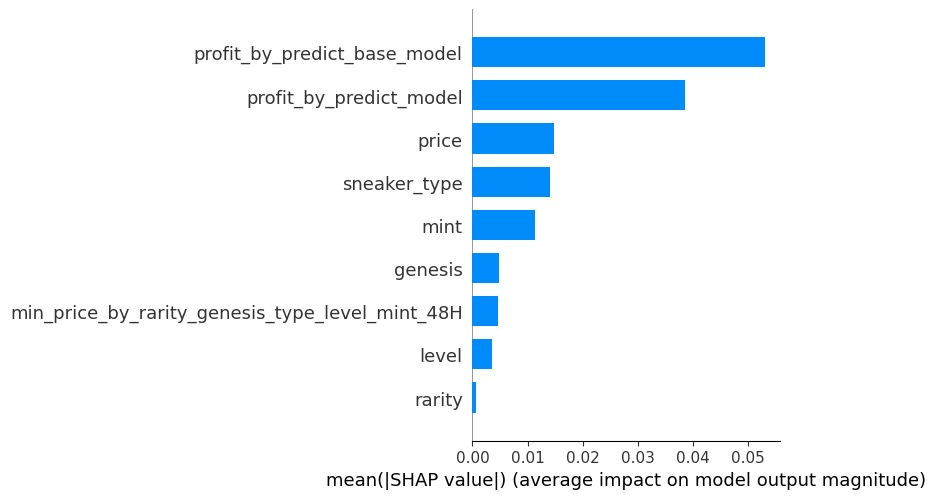

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [76]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1068066	total: 610us	remaining: 610ms
1:	learn: 0.1056085	total: 1.32ms	remaining: 658ms
2:	learn: 0.1044554	total: 1.82ms	remaining: 606ms
3:	learn: 0.1035556	total: 2.35ms	remaining: 584ms
4:	learn: 0.1026554	total: 2.87ms	remaining: 572ms
5:	learn: 0.1014298	total: 3.35ms	remaining: 556ms
6:	learn: 0.1004976	total: 3.89ms	remaining: 552ms
7:	learn: 0.0992946	total: 4.41ms	remaining: 546ms
8:	learn: 0.0984883	total: 4.8ms	remaining: 529ms
9:	learn: 0.0974260	total: 5.26ms	remaining: 521ms
10:	learn: 0.0966343	total: 5.71ms	remaining: 514ms
11:	learn: 0.0958734	total: 6.17ms	remaining: 508ms
12:	learn: 0.0947875	total: 6.63ms	remaining: 503ms
13:	learn: 0.0941596	total: 7.07ms	remaining: 498ms
14:	learn: 0.0934618	total: 7.46ms	remaining: 490ms
15:	learn: 0.0928993	total: 7.88ms	remaining: 485ms
16:	learn: 0.0922873	total: 8.29ms	remaining: 479ms
17:	learn: 0.0915213	total: 8.66ms	remaining: 473ms
18:	learn: 0.0903105	total: 8.97ms	remaining: 463ms
19:	learn: 0.0895978	tot

In [77]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': -0.69,
 'MAE': 0.06,
 'MSE': 0.01,
 'RMSE': 0.099,
 'MAPE': 17680798537086.39}

In [78]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [79]:
submission.profit.sum()

2.954500000000001

In [80]:
submission

,profit,pred
0,0.2680,0.288
1,0.1355,0.130
2,0.0605,0.145
3,0.1255,0.094
4,0.0655,0.119
5,0.1735,0.127
6,0.0305,0.169
7,0.2700,0.271
8,0.0000,0.106
9,0.1260,0.154


In [81]:
submission[submission['pred'] > 0.05].profit.sum()

2.9645000000000006

In [82]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': -0.668,
 'MAE': 0.06,
 'MSE': 0.01,
 'RMSE': 0.098,
 'MAPE': 18347998481881.996}

## Fit full Model

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.0989934	total: 3.78ms	remaining: 3.78s
1:	learn: 0.0979865	total: 4.51ms	remaining: 2.25s
2:	learn: 0.0972565	total: 5.15ms	remaining: 1.71s
3:	learn: 0.0960406	total: 5.69ms	remaining: 1.42s
4:	learn: 0.0948574	total: 6.22ms	remaining: 1.24s
5:	learn: 0.0938976	total: 6.78ms	remaining: 1.12s
6:	learn: 0.0930777	total: 7.38ms	remaining: 1.05s
7:	learn: 0.0924158	total: 7.9ms	remaining: 979ms
8:	learn: 0.0917352	total: 8.38ms	remaining: 922ms
9:	learn: 0.0911390	total: 8.81ms	remaining: 873ms
10:	learn: 0.0902524	total: 9.17ms	remaining: 824ms
11:	learn: 0.0894738	total: 9.54ms	remaining: 786ms
12:	learn: 0.0888619	total: 9.9ms	remaining: 752ms
13:	learn: 0.0882528	total: 10.3ms	remaining: 722ms
14:	learn: 0.0877600	total: 10.6ms	remaining: 699ms
15:	learn: 0.0869658	total: 11ms	remaining: 675ms
16:	learn: 0.0862356	total: 11.4ms	remaining: 657ms
17:	learn: 0.0858537	total: 11.7ms	remaining: 641ms
18:	learn: 0.0854238	total: 12.1ms	remaining: 626ms
19:	learn: 0.0850172	total

In [84]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
167    0.0870
168    0.0625
169    0.1025
170    0.0315
171    0.0775
Name: target, Length: 172, dtype: float64

### Test

In [85]:
i=102

In [86]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663061828,
 'mrk_id': 28651,
 'token_id': 41385,
 'event': 'buy',
 'wallet_from': '0x6d3489da64a34663c54500aee7a748f1efe4d576',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 0.87,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'coacher',
 'level': 5,
 'base_performance': 2.5,
 'base_fortune': 7.2,
 'base_joy': 6.4,
 'base_durability': 5.2,
 'performance': 19.0,
 'fortune': 10.7,
 'joy': 9.4,
 'durability': 7.7,
 'mint': 2,
 'parent1': 37592.0,
 'parent2': 38844.0,
 'genesis': False,
 'parent1_sneaker_type': 'hiker',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 293.08856531,
 'price_azy': 0.08815466,
 'price_amt': 0.54666385,
 'wallet_from_buy_count': 6,
 'wallet_from_all_count': 33,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 60,
 'buy_count_24H': 290,
 'buy_count_48H': 524,
 'sell_count_12H': 223,
 'sell_count_24H': 682,
 'sell_count_48H': 1225,
 'cancel_count_12H': 115,
 'cancel_count_24H':

In [87]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [88]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                              common
sneaker_type                                       coacher
genesis                                              False
level                                                    5
mint                                                     2
min_price_by_rarity_genesis_type_level_mint_48H       0.69
price                                                 0.87
profit_by_predict_model                             -0.067
profit_by_predict_base_model                        -0.034
dtype: object

In [89]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

-0.023

In [90]:
data.iloc[i]['profit']

-0.0625

iteritems is deprecated and will be removed in a future version. Use .items instead.


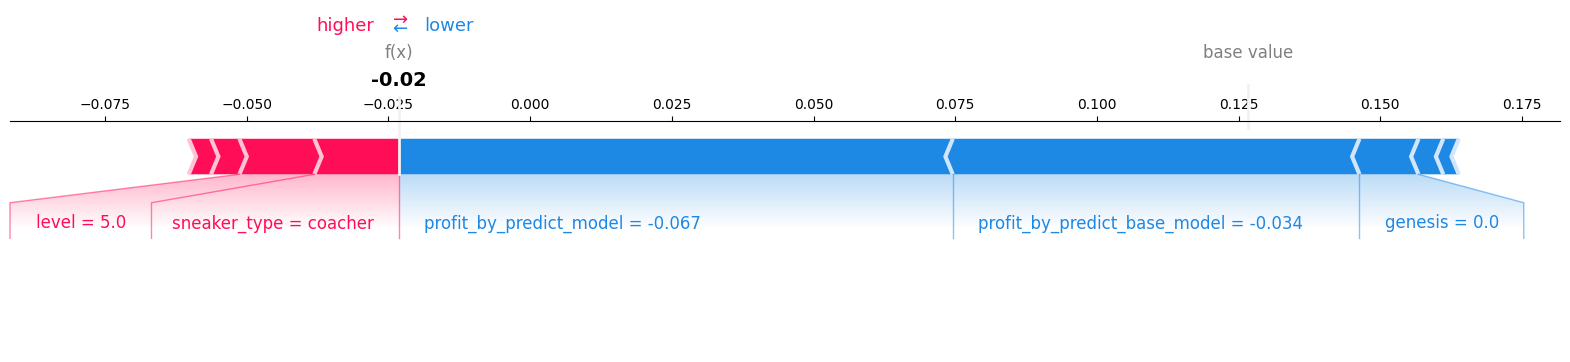

In [91]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)